# Sionna SYS meets Sionna RT

In this notebook, you will learn how to
- Setup a Sionna RT scene;
- Generate channel impulse responses;
- Schedule users, allocate power, and select the modulation and coding scheme (MCS) via Sionna SYS.

This is an advanced notebook. We recommend first exploring the tutorials on 
[physical layer abstraction](https://nvlabs.github.io/sionna/sys/tutorials/PHY_Abstraction.html), [link
adaptation](https://nvlabs.github.io/sionna/sys/tutorials/LinkAdaptation.html), and [scheduling](https://nvlabs.github.io/sionna/sys/tutorials/Scheduling.html).

If you are new to Sionna RT, consider exploring
the [related tutorials](https://nvlabs.github.io/sionna/rt/tutorials.html) first.

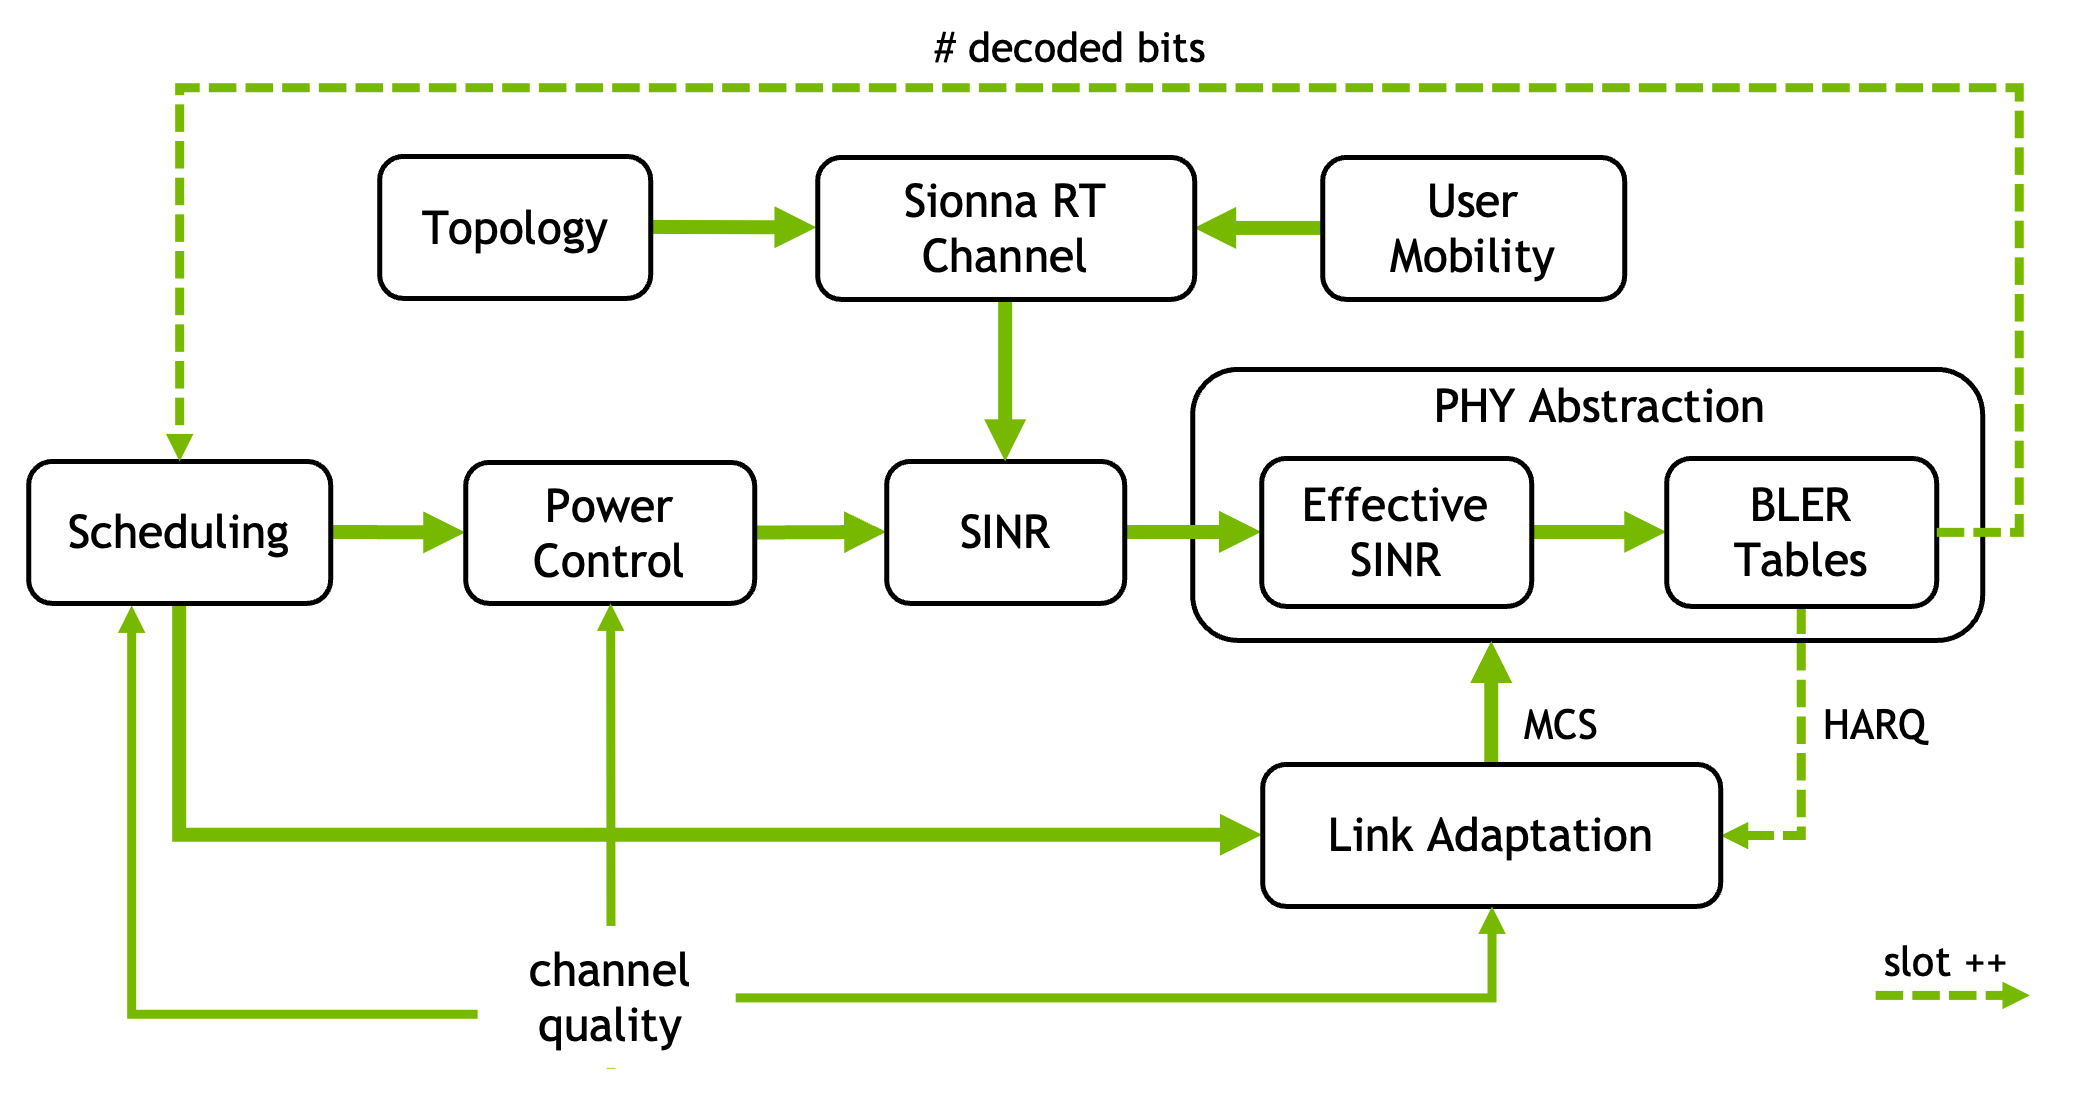

## Imports

We first import Sionna and the relevant external libraries:

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    if gpu_num!="":
        print(f'\nUsing GPU {gpu_num}\n')
    else:
        print('\nUsing CPU\n')
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

# Import Sionna
try:
    import sionna.phy
    import sionna.sys
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)


Using GPU 0



E0000 00:00:1744146146.936841  283086 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744146146.945455  283086 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744146146.966529  283086 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744146146.966559  283086 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744146146.966562  283086 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744146146.966564  283086 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
# Additional external libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# Sionna components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, \
    RadioMapSolver, PathSolver, subcarrier_frequencies, Camera
from sionna.phy import config
from sionna.phy.mimo import StreamManagement
from sionna.phy.ofdm import ResourceGrid, RZFPrecodedChannel, LMMSEPostEqualizationSINR
from sionna.phy.constants import BOLTZMANN_CONSTANT
from sionna.phy.nr.utils import decode_mcs_index
from sionna.phy.utils import log2, dbm_to_watt, lin_to_db
from sionna.sys import PHYAbstraction, OuterLoopLinkAdaptation, \
    PFSchedulerSUMIMO, downlink_fair_power_control
from sionna.sys.utils import spread_across_subcarriers

# Internal computational precision
config.precision = 'single'  # 'single' or 'double'

# Set random seed for reproducibility
config.seed = 48

# Toggle to False to use the preview widget
# instead of rendering for scene visualization
no_preview = True

I0000 00:00:1744146151.950373  283086 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4257 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


## Simulation parameters

We start by defining the main simulation parameters that will be used throughout
the notebook.  
These include the OFDM resource grid, base station placement and
transmit power, user mobility, and BLER target for link adaptation.

In this notebook we consider that communication is in the downlink direction
from la single base station to multiple users.

In [3]:
# Number of simulated slots
num_slots = 200

# Time/frequency resource grid
carrier_frequency = 3.5e9
num_subcarriers = 128
subcarrier_spacing = 30e3
num_ofdm_symbols = 12

# Start/end 3D position of the users
# You can try and change these values to see how the system behaves
ut_pos_start = np.array([[-25,   0, 1.5],  # user 1
                         [24,  55, 1.5],  # user 2
                         [88,   0, 1.5]])  # user 3

ut_pos_end = np.array([[-25,  30, 1.5],    # user 1
                       [24,  15, 1.5],    # user 2
                       [65,    0, 1.5]])   # user 3

# Base station position and look-at direction
bs_pos = np.array([32.5, 10.5, 23])
bs_look_at = np.array([22, -8, 0])

# Number of users and base stations
num_bs = 1
num_ut = ut_pos_start.shape[0]

# Environment temperature
temperature = 294  # [K]

# BLER target value
bler_target = .1  # in [0; 1]

# MCS table index
mcs_table_index = 1

# Base station transmit power
# Low power is sufficient here thanks to lack of interference
bs_power_dbm = 10  # [dBm]
bs_power_watt = dbm_to_watt(bs_power_dbm)  # [W]

# Number of antennas at the transmitter and receiver
num_bs_ant = num_ut
num_ut_ant = 1

In [4]:
# Number of streams per user and base station
num_streams_per_ut = num_ut_ant
num_streams_per_bs = num_ut_ant * num_ut

# Noise power per subcarrier
no = BOLTZMANN_CONSTANT * temperature * subcarrier_spacing

# Stream management: Rx to Tx association
# Since there is only a single BS, all UTs are connected to it
rx_tx_association = np.ones([num_ut, num_bs])
stream_management = StreamManagement(rx_tx_association, num_streams_per_bs)

# OFDM resource grid
resource_grid = ResourceGrid(num_ofdm_symbols=num_ofdm_symbols,
                             fft_size=num_subcarriers,
                             subcarrier_spacing=subcarrier_spacing,
                             num_tx=num_ut,
                             num_streams_per_tx=num_streams_per_ut)

# Subcarrier frequencies
frequencies = subcarrier_frequencies(num_subcarriers=num_subcarriers,
                                     subcarrier_spacing=subcarrier_spacing)

## Scene creation

As the second step, we load the desired scene from Sionna RT. We then need
to configure it and add the base station and users along straight trajectories.

Rather than moving the users in an iterative fashion, as shown in the [Tutorial on Mobility](https://nvlabs.github.io/sionna/rt/tutorials/Mobility.html#Controlling-Position-and-Orientation-of-Scene-Objects),
we will place receivers at all future positions along the desired trajectories
at once and compute the
channel frequency responses (CFRs) in advance. During evaluation, the
appropriate CFRs will be selected iteratively based on user positions. 

In [5]:
# Configure Sionna RT
p_solver = PathSolver()

# Load the scene
scene = load_scene(sionna.rt.scene.simple_street_canyon)

# Set the scene parameters
scene.frequency = carrier_frequency
scene.bandwidth = num_subcarriers*subcarrier_spacing
scene.tx_array = PlanarArray(
    num_rows=num_bs_ant, num_cols=1, pattern="tr38901", polarization='V')
scene.rx_array = PlanarArray(
    num_rows=1, num_cols=num_ut_ant, pattern="dipole", polarization='V')

# Add base station to the scene
scene.add(Transmitter(f"bs0", position=bs_pos, look_at=bs_look_at,
                      power_dbm=bs_power_dbm, display_radius=3))

# Emulate moving users by placing multiple receivers along a straight line
step = (ut_pos_end - ut_pos_start) / (num_slots - 1)

# We add all users at all future positions at once
for slot in range(num_slots):
    pos_curr = ut_pos_start + slot * step
    # Add users
    for ut in range(num_ut):
        scene.add(Receiver(f"ut{ut}_slot{slot}", position=pos_curr[ut, :],
                  display_radius=1, color=[0, 0, 0]))

## Channel generation via Sionna RT

In [6]:
# Path solver: Compute propagation paths between the antennas of all
# transmitters and receivers in the scene using ray tracing
paths = p_solver(scene, max_depth=8, refraction=False)

# Transform to channel frequency response (CFR)
# [num_steps*num_ut, num_rx_ant, num_tx, num_tx_ant, num_ofdm_symbols, num_subcarriers]
h_freq = paths.cfr(frequencies=frequencies,
                   sampling_frequency=1/resource_grid.ofdm_symbol_duration,
                   num_time_steps=resource_grid.num_ofdm_symbols,
                   out_type="tf")

# [num_steps*num_ut, 1, num_ut_ant, num_bs, num_bs_ant, num_ofdm_symbols, num_subcarriers]
h_freq = tf.expand_dims(h_freq, axis=1)

# [num_steps, num_ut, num_ut_ant, num_bs, num_bs_ant, num_ofdm_symbols, num_subcarriers]
h_freq = tf.reshape(h_freq, [num_slots, num_ut] + h_freq.shape[2:])

We next compute the radio map and visualize the corresponding SINR, along with the user and base
station positions.  

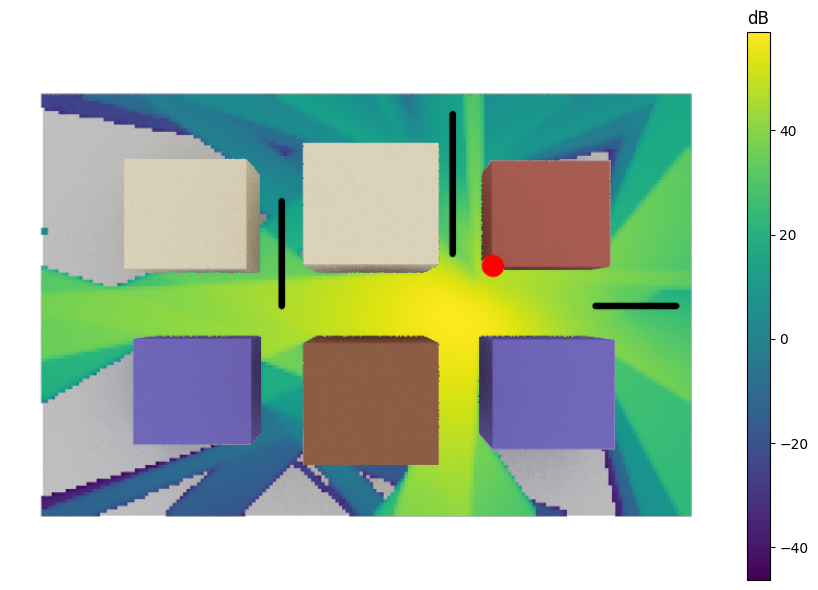

In [7]:
# Compute the Radio Map for the scene and visualize it
rm_solver = RadioMapSolver()
rm = rm_solver(scene, max_depth=8, refraction=False,
               cell_size=(1, 1), samples_per_tx=10000000)

if no_preview:
    cam = Camera(position=[-0, 0, 250],
                 orientation=np.array([0, np.pi/2, -np.pi/2]))
    scene.render(camera=cam,
                 radio_map=rm,
                 rm_metric="sinr",
                 rm_show_color_bar=True)
else:
    scene.preview(radio_map=rm, rm_metric="sinr")

As shown in the figure above, each of the three users moves along a different
linear trajectory with different channel conditions.  
We will explore how link adaptation, power control, and scheduling adapt to
dynamic channel conditions and optimize system performance.

## System-level simulation

After creating the scene and generating the channel for each user across slots,
we can now perform system-level simulations with Sionna SYS.

We first instantiate the main classes:
- [PHYAbstraction](https://nvlabs.github.io/sionna/sys/api/abstraction.html#sionna.sys.PHYAbstraction), to bypass the physical layer computations;
- [OuterLoopLinkAdaptation](https://nvlabs.github.io/sionna/sys/api/link_adaptation.html#sionna.sys.OuterLoopLinkAdaptation), to select the modulation and coding scheme (MCS);
- [PFSchedulerSUMIM](https://nvlabs.github.io/sionna/sys/api/scheduling.html#sionna.sys.PFSchedulerSUMIMO), to schedule users across the OFDM resource grid in a
  single-user MIMO system.

The downlink transmission power is distributed fairly across users via the function [downlink_fair_power_control](https://nvlabs.github.io/sionna/sys/api/power_control.html#sionna.sys.downlink_fair_power_control).


In [8]:
# Initialize the PHYAbstraction class
phy_abs = PHYAbstraction()

# Instantiate an OLLA object
olla = OuterLoopLinkAdaptation(phy_abs,
                               num_ut=num_ut,
                               bler_target=bler_target,
                               batch_size=[num_bs])

# Instantiate a Scheduler
scheduler = PFSchedulerSUMIMO(
    num_ut,
    num_subcarriers,
    num_ofdm_symbols,
    batch_size=[num_bs],
    num_streams_per_ut=num_streams_per_ut,
    beta=.9)

We will next define the operations performed at each slot, namely:
- Scheduling users across the resource grid;
- Allocating transmit power to each user;
- Computing the SINR;
- Selecting MCS via link adaptation;
- Generating decoded bits and HARQ feedback via physical layer abstraction.

*Remark*: For simplicity, we assume perfect channel knowledge in
- Precoder and equalizer computation for SINR calculation;
- Achievable rate estimation for scheduling purposes;
- Channel quality feedback for link adaptation.

In [9]:
def estimate_achievable_rate(channel_gain, no):
    """ Estimate the achievable rate via Shannon formula """
    # [num_ut, num_ut_ant, num_bs, num_bs_ant, num_ofdm_symbols, num_subcarriers]
    rate_achievable_est = log2(tf.cast(1, tf.float32) + channel_gain / no)
    # [num_ut, num_bs, num_ofdm_symbols, num_subcarriers]
    rate_achievable_est = tf.reduce_mean(rate_achievable_est, axis=[-3, -5])
    # [num_bs, num_ofdm_symbols, num_subcarriers, num_ut]
    rate_achievable_est = tf.transpose(rate_achievable_est, [1, 2, 3, 0])
    return rate_achievable_est

In [25]:
# To speed-up the computations, we will use JIT compilation.
@tf.function(jit_compile=True)
def step(h, harq_feedback, sinr_eff_feedback, num_decoded_bits):
    """ Perform system-level operations at a single slot:
    - Scheduling
    - Power control
    - SINR computation
    - Link adaptation
    - PHY abstraction 
    Perfect channel knowledge at both transmitter and receivers is assumed.
    """
    # Compute channel gain
    # [num_ut, num_ut_ant, num_bs, num_bs_ant, num_ofdm_symbols, num_subcarriers]
    channel_gain = tf.cast(tf.abs(h)**2, tf.float32)

    # Estimate achievable rate via Shannon formula
    # [num_bs, num_ofdm_symbols, num_subcarriers, num_ut]
    rate_achievable_est = estimate_achievable_rate(channel_gain, no)

    # --------- #
    # Scheduler #
    # --------- #
    # Determine which stream of which user is scheduled on which RE
    # [num_bs, num_ofdm_symbols, num_subcarriers, num_ut, num_streams_per_ut]
    is_scheduled = scheduler(num_decoded_bits,
                             rate_achievable_est)

    # Determine the index of the scheduled user for every RE
    # [num_bs, num_ofdm_symbols, num_subcarriers]
    ut_scheduled = tf.argmax(tf.reduce_sum(
        tf.cast(is_scheduled, tf.int32), axis=-1), axis=-1)

    # Compute the number of allocated REs per user
    # [num_bs, num_ut]
    num_allocated_re = tf.reduce_sum(
        tf.cast(is_scheduled, tf.int32), axis=[-4, -3, -1])

    # Compute the average pathloss per user
    # [num_ut, num_bs]
    pathloss_per_ut = tf.reduce_mean(1 / channel_gain,
                                     axis=[1, 3, 4, 5])
    # [num_bs, num_ut]
    pathloss_per_ut = tf.transpose(pathloss_per_ut, [1, 0])

    # ------------- #
    # Power control #
    # ------------- #
    # Allocate power to each user in fair manner
    # [num_bs, num_ut]
    tx_power_per_ut, _ = downlink_fair_power_control(
        pathloss_per_ut,
        no,
        num_allocated_re,
        bs_max_power_dbm=bs_power_dbm,
        # in [0;1]; Minimum ratio of power for each user
        guaranteed_power_ratio=.5,
        fairness=0)  # Fairness parameter>=0. If 0, sum throughput across users is maximized

    # Spread power uniformly across allocated subcarriers and streams
    # [num_bs, num_tx_per_bs, num_streams_per_tx, num_ofdm_sym, num_subcarriers]
    tx_power = spread_across_subcarriers(
        tf.expand_dims(tx_power_per_ut, axis=-2),
        is_scheduled,
        num_tx=num_bs)

    # ---------------- #
    # SINR computation #
    # ---------------- #
    # Effective channel upon regularized zero-forcing precoding
    precoded_channel = RZFPrecodedChannel(resource_grid=resource_grid,
                                          stream_management=stream_management)
    h_eff = precoded_channel(h[tf.newaxis, ...], tx_power=tx_power, alpha=no)

    # LMMSE post-equalization SINR computation
    lmmse_posteq_sinr = LMMSEPostEqualizationSINR(resource_grid=resource_grid,
                                                  stream_management=stream_management)
    # [batch_size, num_ofdm_symbols, num_subcarriers, num_ut, num_streams_per_ut]
    sinr = lmmse_posteq_sinr(h_eff, no=no, interference_whitening=True)

    # --------------- #
    # Link adaptation #
    # --------------- #
    # [num_bs, num_ut]
    mcs_index = olla(num_allocated_re=num_allocated_re,
                     sinr_eff=sinr_eff_feedback,
                     mcs_table_index=mcs_table_index,
                     mcs_category=1,  # downlink
                     harq_feedback=harq_feedback)

    # --------------- #
    # PHY abstraction #
    # --------------- #
    # [num_bs, num_ut]
    num_decoded_bits, harq_feedback, sinr_eff_true, *_ = phy_abs(
        mcs_index,
        sinr=sinr,
        mcs_table_index=mcs_table_index,
        mcs_category=1)  # downlink)

    sinr_eff_db_true = lin_to_db(sinr_eff_true)

    # SINR feedback for OLLA
    sinr_eff_feedback = tf.where(num_allocated_re > 0, sinr_eff_true, 0)

    # Spectral efficiency
    # [num_bs, num_ut]
    mod_order, coderate = decode_mcs_index(
        mcs_index,
        table_index=mcs_table_index,
        is_pusch=False)

    se_la = tf.where(harq_feedback == 1,
                     tf.cast(mod_order, coderate.dtype) * coderate,
                     tf.cast(0, tf.float32))

    # Shannon capacity
    se_shannon = log2(1 + sinr_eff_true)
    return harq_feedback, sinr_eff_feedback, num_decoded_bits, \
        mcs_index, se_la, se_shannon, sinr_eff_db_true, \
        scheduler.pf_metric, ut_scheduled

We are now ready to simulate the system across all slots!

In [26]:
# Initialize history
harq_feedback_hist = np.full([num_slots, num_bs, num_ut], np.nan)
se_la_hist = np.full([num_slots, num_bs, num_ut], np.nan)
se_shannon_hist = np.full([num_slots, num_bs, num_ut], np.nan)
sinr_eff_db_hist = np.full([num_slots, num_bs, num_ut], np.nan)
is_scheduled_hist = np.full(
    [num_slots, num_bs, num_ofdm_symbols, num_subcarriers], np.nan)

# Initialize HARQ feedback to -1 (missing)
harq_feedback = - tf.ones([num_bs, num_ut], dtype=tf.int32)

# Initialize SINR feedback
sinr_eff_feedback = tf.zeros([num_bs, num_ut], dtype=tf.float32)

# Initialize n. decoded bits
num_decoded_bits = tf.zeros([num_bs, num_ut], dtype=tf.int32)

for ii in range(num_slots):
    # [num_ut, num_ut_ant, num_bs, num_bs_ant, num_ofdm_symbols, num_subcarriers]
    h = h_freq[ii, ...]

    harq_feedback, sinr_eff_feedback, num_decoded_bits, mcs_index, \
        se_la, se_shannon, sinr_eff_db_true, \
        pf_metric, ut_scheduled = \
        step(h, harq_feedback, sinr_eff_feedback, num_decoded_bits)

    # Record history
    harq_feedback_hist[ii, :] = harq_feedback.numpy()
    se_la_hist[ii, :] = se_la.numpy()
    se_shannon_hist[ii, :] = se_shannon.numpy()
    sinr_eff_db_hist[ii, :] = sinr_eff_db_true.numpy()
    is_scheduled_hist[ii, ...] = ut_scheduled.numpy()

# Mask metrics when user is not scheduled
not_scheduled = harq_feedback_hist == -1
se_la_hist[not_scheduled] = np.nan
se_shannon_hist[not_scheduled] = np.nan
sinr_eff_db_hist[not_scheduled] = np.nan
harq_feedback_hist[not_scheduled] = np.nan

Finally, we visualize the achieved performance, in terms of achieved spectral
efficiency and transport block error rate (TBLER).

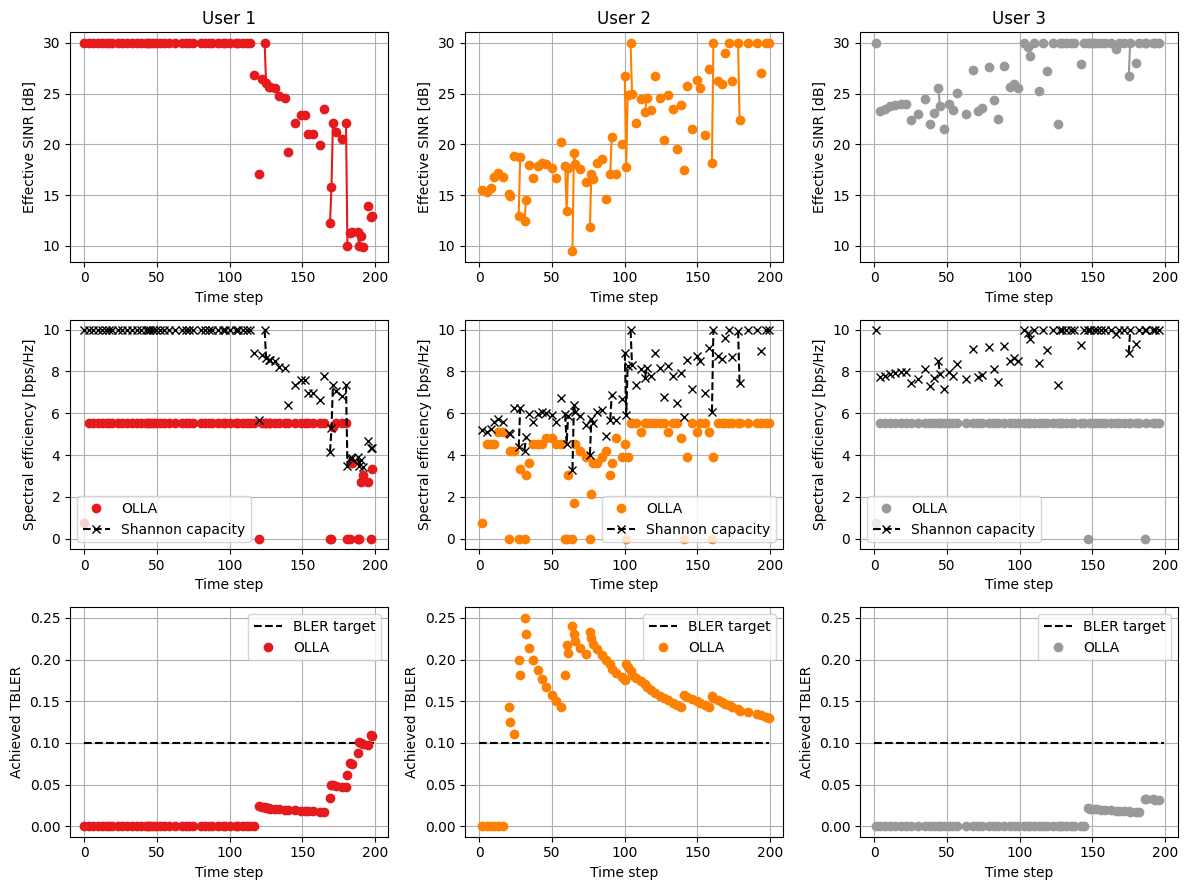

In [27]:
bs = 0

# Create a color map or list of colors
colors = plt.cm.Set1(np.linspace(0, 1, num_ut))

linestyle = ' '
label = 'OLLA'
fig, axs = plt.subplots(3, num_ut, sharex='col', sharey='row',
                        figsize=(4*num_ut, 9))
if num_ut == 1:
    axs = axs.reshape(3, 1)

for ax in axs.flat:
    ax.yaxis.set_tick_params(labelleft=True)
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.grid()


for ut in range(num_ut):
    axs[0, ut].plot(sinr_eff_db_hist[:, bs, ut], color=colors[ut],
                    marker='o')
    axs[0, ut].set_ylabel('Effective SINR [dB]')
    axs[0, ut].set_xlabel('Time step')
    axs[0, ut].set_title(f'User {ut+1}')

for ut in range(num_ut):
    axs[1, ut].plot(se_la_hist[:, bs, ut], color=colors[ut],
                    marker='o', linestyle=linestyle, label=label)
    axs[1, ut].plot(se_shannon_hist[:, bs, ut], '--k',
                    marker='x', label='Shannon capacity')
    axs[1, ut].set_ylabel('Spectral efficiency [bps/Hz]')
    axs[1, ut].set_xlabel('Time step')
    axs[1, ut].legend()

    axs[2, ut].plot([0, num_slots - 1], [bler_target]
                    * 2, '--k', label='BLER target')

    ind_ok = np.isnan(harq_feedback_hist[:, bs, ut]) == False
    bler = 1 - \
        np.cumsum(harq_feedback_hist[ind_ok, bs, ut]
                  ) / np.arange(1, sum(ind_ok) + 1)
    bler_vec = np.full([num_slots], np.nan)
    bler_vec[ind_ok] = bler

    axs[2, ut].plot(bler_vec, color=colors[ut],
                    marker='o', linestyle=linestyle, label=label)
    axs[2, ut].set_ylabel('Achieved TBLER')
    axs[2, ut].set_xlabel('Time step')
    axs[2, ut].legend()
fig.tight_layout()
plt.show()

As shown in the figure above, link adaptation is able to track the
effective SINR and adjusts the MCS to the channel conditions.  
The TBLER is maintained close to the target value, except when the SINR reaches extreme
values, where no MCS index meeting the desired BLER exists.

It is also interesting to visualize the scheduling decisions over time across
the resource grid.  
We recall that at most one user is scheduled in each resource element, under the
single-user MIMO assumption.

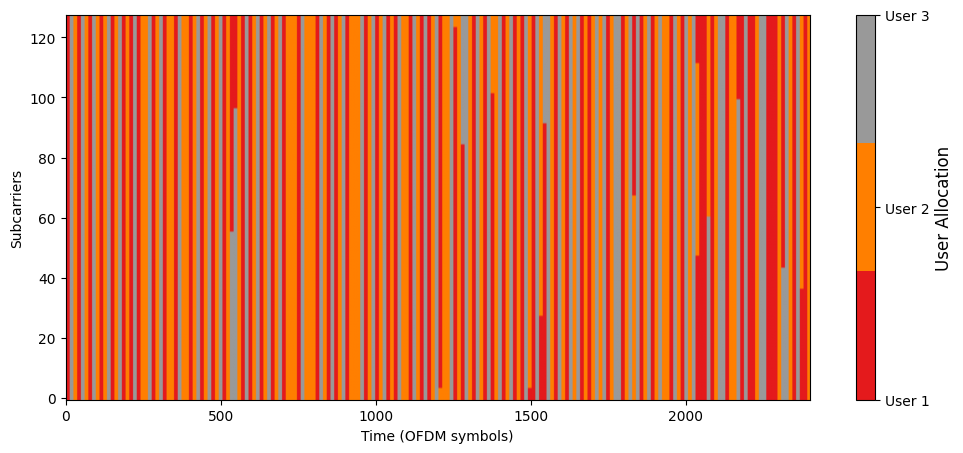

In [28]:
cmap = plt.get_cmap('Set1', num_ut)

is_scheduled_hist = np.reshape(is_scheduled_hist,
                               [num_slots*num_ofdm_symbols, num_subcarriers])

# Configure plot
plt.figure(figsize=(12, 5))
plt.imshow(is_scheduled_hist.T, cmap=cmap, aspect='auto')

# Add colorbar with custom ticks and labels
cbar = plt.colorbar(ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['User 1', 'User 2', 'User 3'])
cbar.set_label('User Allocation', fontsize=12)
plt.gca().invert_yaxis()
plt.xlabel('Time (OFDM symbols)')
plt.ylabel('Subcarriers')
plt.show()

## Conclusions

[Sionna SYS](https://nvlabs.github.io/sionna/sys/index.html) and [Sionna RT](https://nvlabs.github.io/sionna/rt/index.html) are fully compatible: for a given scene, Sionna RT generates
the channel impulse response which Sionna SYS can then use to perform
system level simulations.  

Although this notebook illustrates only a simple scene with one base station, more
complex scenarios with many base stations and users can be simulated.  
The only limit is your imagination!